In [1]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\DS_Material\CSU\CV\SHAP-PRJ\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_config(transform_output="pandas")

In [3]:
data = fetch_california_housing(as_frame=True)

In [4]:
data

{'data':        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
 4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
 ...       ...       ...       ...        ...         ...       ...       ...   
 20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
 20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
 20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
 20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
 20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   
 
        Longitude 

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
X,y = data.data,data.target

In [7]:
feature_names = data.feature_names
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [10]:
X.shape

(20640, 8)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
print(f"Training Data SHape : {X_train.shape}")
print(f"Testing data Shape : {X_test.shape}")

Training Data SHape : (16512, 8)
Testing data Shape : (4128, 8)


## Model

In [13]:
xgb_model = XGBRegressor(objective='reg:squarederror',random_state = 42,n_jobs = -1,learning_rate = 0.2,n_estimators = 200,
                         reg_lambda = 50,max_depth = 7,gamma = 0.05)

In [14]:
xgb_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [16]:
#CAlculate RMSE and R2 score
rmse_train = root_mean_squared_error(y_train,y_train_pred)
rmse_test = root_mean_squared_error(y_test_pred,y_test_pred)

In [17]:
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

In [18]:
print (f"Train RMSE : {rmse_train} R2_train : {r2_train}")
print (f"Test RMSE : {rmse_test} R2_test : {r2_test}")


Train RMSE : 0.28992970204248986 R2_train : 0.937118041433422
Test RMSE : 0.0 R2_test : 0.8472358680056411


## HP Tunning

In [19]:

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(func= objective,n_trials=50,show_progress_bar=True,n_jobs=-1)

[I 2025-12-07 07:39:28,886] A new study created in memory with name: no-name-c84dfe1b-c0c7-429a-909f-3c345224a28a
Best trial: 9. Best value: 0.680844:   2%|▏         | 1/50 [00:01<01:10,  1.45s/it]

[I 2025-12-07 07:39:30,326] Trial 9 finished with value: 0.6808436241861968 and parameters: {'learning_rate': 0.04019103901124872, 'n_estimators': 71, 'max_depth': 3, 'reg_lambda': 12.726976254745896, 'gamma': 0.7935273605164126, 'subsample': 0.9037961887908067}. Best is trial 9 with value: 0.6808436241861968.


Best trial: 4. Best value: 0.833858:   4%|▍         | 2/50 [00:02<01:04,  1.34s/it]

[I 2025-12-07 07:39:31,573] Trial 4 finished with value: 0.8338575731722433 and parameters: {'learning_rate': 0.18693324098322164, 'n_estimators': 73, 'max_depth': 10, 'reg_lambda': 9.51981203756619, 'gamma': 0.4898663023471441, 'subsample': 0.7372053388970738}. Best is trial 4 with value: 0.8338575731722433.


Best trial: 4. Best value: 0.833858:   6%|▌         | 3/50 [00:03<00:44,  1.05it/s]

[I 2025-12-07 07:39:32,082] Trial 7 finished with value: 0.811457063248064 and parameters: {'learning_rate': 0.26391974677760044, 'n_estimators': 362, 'max_depth': 8, 'reg_lambda': 55.74870352121196, 'gamma': 1.6935549415422564, 'subsample': 0.982368683335004}. Best is trial 4 with value: 0.8338575731722433.
[I 2025-12-07 07:39:32,144] Trial 3 finished with value: 0.8144773897468317 and parameters: {'learning_rate': 0.1878264663621756, 'n_estimators': 302, 'max_depth': 4, 'reg_lambda': 47.239667552943075, 'gamma': 1.9826588586925389, 'subsample': 0.7629150127206994}. Best is trial 4 with value: 0.8338575731722433.


Best trial: 5. Best value: 0.83431:  10%|█         | 5/50 [00:03<00:21,  2.10it/s] 

[I 2025-12-07 07:39:32,305] Trial 5 finished with value: 0.8343101496695228 and parameters: {'learning_rate': 0.26899921174588237, 'n_estimators': 115, 'max_depth': 10, 'reg_lambda': 25.487732321218008, 'gamma': 0.4386891197734526, 'subsample': 0.7547990134658582}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  14%|█▍        | 7/50 [00:04<00:18,  2.30it/s]

[I 2025-12-07 07:39:33,071] Trial 1 finished with value: 0.8112541183005973 and parameters: {'learning_rate': 0.2608080614361133, 'n_estimators': 438, 'max_depth': 3, 'reg_lambda': 87.76128624315491, 'gamma': 1.1790748243837739, 'subsample': 0.9445762606007074}. Best is trial 5 with value: 0.8343101496695228.
[I 2025-12-07 07:39:33,205] Trial 10 finished with value: 0.829614167747206 and parameters: {'learning_rate': 0.1268900896250686, 'n_estimators': 224, 'max_depth': 7, 'reg_lambda': 13.262564714927786, 'gamma': 1.0445759265452945, 'subsample': 0.7068734172543165}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  16%|█▌        | 8/50 [00:04<00:16,  2.47it/s]

[I 2025-12-07 07:39:33,531] Trial 11 finished with value: 0.8093447805767053 and parameters: {'learning_rate': 0.2539055817908248, 'n_estimators': 458, 'max_depth': 3, 'reg_lambda': 95.18669929869085, 'gamma': 1.6246561777183202, 'subsample': 0.7584430927637428}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  18%|█▊        | 9/50 [00:05<00:17,  2.39it/s]

[I 2025-12-07 07:39:33,979] Trial 8 finished with value: 0.8309623753114266 and parameters: {'learning_rate': 0.20673410057918626, 'n_estimators': 495, 'max_depth': 10, 'reg_lambda': 33.64566924805146, 'gamma': 0.8134272962607458, 'subsample': 0.9456272880487329}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  22%|██▏       | 11/50 [00:05<00:12,  3.23it/s]

[I 2025-12-07 07:39:34,282] Trial 6 finished with value: 0.826747548400727 and parameters: {'learning_rate': 0.19742944910267504, 'n_estimators': 485, 'max_depth': 7, 'reg_lambda': 93.57380980205996, 'gamma': 0.891849771479639, 'subsample': 0.9188294694351657}. Best is trial 5 with value: 0.8343101496695228.
[I 2025-12-07 07:39:34,419] Trial 0 finished with value: 0.8059551977836745 and parameters: {'learning_rate': 0.12109238406847582, 'n_estimators': 456, 'max_depth': 3, 'reg_lambda': 89.78638660692842, 'gamma': 1.5702232778465386, 'subsample': 0.7898033130569524}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  22%|██▏       | 11/50 [00:05<00:12,  3.23it/s]

[I 2025-12-07 07:39:34,514] Trial 12 finished with value: 0.8235558201275179 and parameters: {'learning_rate': 0.1683493539011402, 'n_estimators': 382, 'max_depth': 9, 'reg_lambda': 90.4877816073271, 'gamma': 1.3460197329188563, 'subsample': 0.9667291021398409}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  26%|██▌       | 13/50 [00:06<00:10,  3.45it/s]

[I 2025-12-07 07:39:34,953] Trial 14 finished with value: 0.7988438066562396 and parameters: {'learning_rate': 0.20296022927421034, 'n_estimators': 217, 'max_depth': 3, 'reg_lambda': 96.6195359383151, 'gamma': 1.723738848769834, 'subsample': 0.8899459017648201}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  28%|██▊       | 14/50 [00:06<00:10,  3.35it/s]

[I 2025-12-07 07:39:35,282] Trial 19 finished with value: 0.7989160121334538 and parameters: {'learning_rate': 0.26688546395156015, 'n_estimators': 112, 'max_depth': 3, 'reg_lambda': 68.49159138184017, 'gamma': 1.6149001611463583, 'subsample': 0.8796977796713997}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 5. Best value: 0.83431:  30%|███       | 15/50 [00:06<00:10,  3.24it/s]

[I 2025-12-07 07:39:35,618] Trial 20 finished with value: 0.8223095952290771 and parameters: {'learning_rate': 0.25256907767805215, 'n_estimators': 90, 'max_depth': 7, 'reg_lambda': 36.92509105453363, 'gamma': 0.911745538919164, 'subsample': 0.99800183259911}. Best is trial 5 with value: 0.8343101496695228.


Best trial: 2. Best value: 0.834844:  34%|███▍      | 17/50 [00:07<00:07,  4.22it/s]

[I 2025-12-07 07:39:35,844] Trial 16 finished with value: 0.811400979965342 and parameters: {'learning_rate': 0.19321172230914976, 'n_estimators': 279, 'max_depth': 4, 'reg_lambda': 77.52941469839861, 'gamma': 1.7160289451286859, 'subsample': 0.8601130849028571}. Best is trial 5 with value: 0.8343101496695228.
[I 2025-12-07 07:39:35,950] Trial 2 finished with value: 0.834843554321849 and parameters: {'learning_rate': 0.26031834164002915, 'n_estimators': 396, 'max_depth': 10, 'reg_lambda': 45.21821974274283, 'gamma': 0.5075544295208287, 'subsample': 0.745167173323718}. Best is trial 2 with value: 0.834843554321849.


Best trial: 2. Best value: 0.834844:  36%|███▌      | 18/50 [00:07<00:13,  2.36it/s]

[I 2025-12-07 07:39:36,845] Trial 22 finished with value: 0.8235860403868217 and parameters: {'learning_rate': 0.29243044469255136, 'n_estimators': 50, 'max_depth': 10, 'reg_lambda': 4.741257815320596, 'gamma': 0.19976224242077456, 'subsample': 0.832430715974797}. Best is trial 2 with value: 0.834843554321849.


Best trial: 2. Best value: 0.834844:  38%|███▊      | 19/50 [00:08<00:11,  2.61it/s]

[I 2025-12-07 07:39:37,130] Trial 23 finished with value: 0.817772369974069 and parameters: {'learning_rate': 0.28620250308642126, 'n_estimators': 73, 'max_depth': 10, 'reg_lambda': 1.4143996827496075, 'gamma': 0.21982220138468356, 'subsample': 0.8436183172840521}. Best is trial 2 with value: 0.834843554321849.


Best trial: 2. Best value: 0.834844:  40%|████      | 20/50 [00:08<00:11,  2.60it/s]

[I 2025-12-07 07:39:37,518] Trial 13 finished with value: 0.8198579967539444 and parameters: {'learning_rate': 0.07579240051122867, 'n_estimators': 268, 'max_depth': 5, 'reg_lambda': 85.35373983400792, 'gamma': 1.2705901212385717, 'subsample': 0.8207314387263616}. Best is trial 2 with value: 0.834843554321849.


Best trial: 2. Best value: 0.834844:  42%|████▏     | 21/50 [00:08<00:09,  2.92it/s]

[I 2025-12-07 07:39:37,755] Trial 24 finished with value: 0.8267251767728404 and parameters: {'learning_rate': 0.2874986885009281, 'n_estimators': 71, 'max_depth': 10, 'reg_lambda': 3.205339707354674, 'gamma': 0.1911331647194845, 'subsample': 0.833175350908326}. Best is trial 2 with value: 0.834843554321849.


Best trial: 2. Best value: 0.834844:  44%|████▍     | 22/50 [00:09<00:09,  2.91it/s]

[I 2025-12-07 07:39:38,108] Trial 18 finished with value: 0.7972665658132939 and parameters: {'learning_rate': 0.14617403746235738, 'n_estimators': 480, 'max_depth': 4, 'reg_lambda': 97.34594878364427, 'gamma': 1.9283761500034236, 'subsample': 0.9987872626687884}. Best is trial 2 with value: 0.834843554321849.


Best trial: 15. Best value: 0.84534:  46%|████▌     | 23/50 [00:10<00:13,  2.01it/s]

[I 2025-12-07 07:39:38,973] Trial 26 finished with value: 0.824503656800036 and parameters: {'learning_rate': 0.2923248377717482, 'n_estimators': 141, 'max_depth': 10, 'reg_lambda': 5.071224035046853, 'gamma': 0.31676627261702434, 'subsample': 0.8254148221173127}. Best is trial 2 with value: 0.834843554321849.
[I 2025-12-07 07:39:39,044] Trial 15 finished with value: 0.8453395806721661 and parameters: {'learning_rate': 0.25459486292857536, 'n_estimators': 257, 'max_depth': 6, 'reg_lambda': 78.50454300989315, 'gamma': 0.26558701291977416, 'subsample': 0.8408380205635567}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  50%|█████     | 25/50 [00:10<00:09,  2.53it/s]

[I 2025-12-07 07:39:39,521] Trial 27 finished with value: 0.8200819159262771 and parameters: {'learning_rate': 0.2922040765496484, 'n_estimators': 169, 'max_depth': 10, 'reg_lambda': 3.3465877583471713, 'gamma': 0.33622417120355175, 'subsample': 0.8106731063943733}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  52%|█████▏    | 26/50 [00:10<00:08,  2.91it/s]

[I 2025-12-07 07:39:39,710] Trial 21 finished with value: 0.8333104749099994 and parameters: {'learning_rate': 0.11954393187579583, 'n_estimators': 183, 'max_depth': 5, 'reg_lambda': 65.46796576604987, 'gamma': 0.0453561494189918, 'subsample': 0.8232654556009803}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  54%|█████▍    | 27/50 [00:11<00:12,  1.87it/s]

[I 2025-12-07 07:39:40,787] Trial 30 finished with value: 0.8363694642117121 and parameters: {'learning_rate': 0.2284161725830941, 'n_estimators': 148, 'max_depth': 9, 'reg_lambda': 26.938707465804637, 'gamma': 0.5111529874281958, 'subsample': 0.8069807812644845}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  56%|█████▌    | 28/50 [00:12<00:12,  1.82it/s]

[I 2025-12-07 07:39:41,371] Trial 31 finished with value: 0.8377267204688793 and parameters: {'learning_rate': 0.2318706335967673, 'n_estimators': 135, 'max_depth': 9, 'reg_lambda': 27.16766389732499, 'gamma': 0.5002240716850183, 'subsample': 0.7115719262057093}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  60%|██████    | 30/50 [00:13<00:08,  2.45it/s]

[I 2025-12-07 07:39:41,742] Trial 25 finished with value: 0.8396985666993109 and parameters: {'learning_rate': 0.06846351247078385, 'n_estimators': 124, 'max_depth': 10, 'reg_lambda': 26.64715293843209, 'gamma': 0.2588470906298177, 'subsample': 0.820304058232853}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:41,920] Trial 32 finished with value: 0.8367034488741798 and parameters: {'learning_rate': 0.2355705147406824, 'n_estimators': 150, 'max_depth': 9, 'reg_lambda': 25.610920209997467, 'gamma': 0.48766777053032084, 'subsample': 0.7170187585786209}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  62%|██████▏   | 31/50 [00:14<00:10,  1.77it/s]

[I 2025-12-07 07:39:42,874] Trial 28 finished with value: 0.8406608429524964 and parameters: {'learning_rate': 0.2964905871049475, 'n_estimators': 172, 'max_depth': 9, 'reg_lambda': 28.285207666294163, 'gamma': 0.017103188357289634, 'subsample': 0.8184086662200689}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:42,905] Trial 33 finished with value: 0.8369492669170129 and parameters: {'learning_rate': 0.22785106266884625, 'n_estimators': 148, 'max_depth': 9, 'reg_lambda': 26.660303661489444, 'gamma': 0.5088380064936353, 'subsample': 0.7012430910900795}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  70%|███████   | 35/50 [00:14<00:04,  3.04it/s]

[I 2025-12-07 07:39:43,745] Trial 17 finished with value: 0.8449282437635182 and parameters: {'learning_rate': 0.11593267278036132, 'n_estimators': 405, 'max_depth': 5, 'reg_lambda': 96.35952572993855, 'gamma': 0.3392064816398612, 'subsample': 0.8520444845783787}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:43,790] Trial 35 finished with value: 0.8382235924250339 and parameters: {'learning_rate': 0.23406935829438097, 'n_estimators': 160, 'max_depth': 6, 'reg_lambda': 24.509001420313965, 'gamma': 0.5427891416053116, 'subsample': 0.715629160876533}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:43,831] Trial 34 finished with value: 0.8393022902822769 and parameters: {'learning_rate': 0.22929686581867748, 'n_estimators': 153, 'max_depth': 9, 'reg_lambda': 24.459020534403212, 'gamma': 0.5028660059966945, 'subsample': 0.7009356652881359}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  72%|███████▏  | 36/50 [00:16<00:07,  1.97it/s]

[I 2025-12-07 07:39:44,992] Trial 29 finished with value: 0.8357918790293004 and parameters: {'learning_rate': 0.046858041793500005, 'n_estimators': 161, 'max_depth': 9, 'reg_lambda': 29.263833913726547, 'gamma': 0.04800144693233771, 'subsample': 0.8180152657738702}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  76%|███████▌  | 38/50 [00:16<00:04,  2.63it/s]

[I 2025-12-07 07:39:45,325] Trial 36 finished with value: 0.8387947638333839 and parameters: {'learning_rate': 0.22845435508854228, 'n_estimators': 354, 'max_depth': 6, 'reg_lambda': 27.3339165536739, 'gamma': 0.5697735844431753, 'subsample': 0.7010566351358654}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:45,460] Trial 39 finished with value: 0.8369146661879331 and parameters: {'learning_rate': 0.225069154207939, 'n_estimators': 184, 'max_depth': 8, 'reg_lambda': 19.906677533397158, 'gamma': 0.6554988903830832, 'subsample': 0.78760816071383}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  80%|████████  | 40/50 [00:17<00:03,  2.82it/s]

[I 2025-12-07 07:39:46,015] Trial 37 finished with value: 0.837944391837061 and parameters: {'learning_rate': 0.22595661194685088, 'n_estimators': 392, 'max_depth': 8, 'reg_lambda': 23.537789542822672, 'gamma': 0.5741229976203219, 'subsample': 0.7081188070494392}. Best is trial 15 with value: 0.8453395806721661.
[I 2025-12-07 07:39:46,180] Trial 38 finished with value: 0.8349484172965196 and parameters: {'learning_rate': 0.2292050985381464, 'n_estimators': 330, 'max_depth': 8, 'reg_lambda': 47.62022299949771, 'gamma': 0.658908180879081, 'subsample': 0.7862206247057975}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  82%|████████▏ | 41/50 [00:18<00:04,  2.19it/s]

[I 2025-12-07 07:39:46,891] Trial 41 finished with value: 0.8338044241284241 and parameters: {'learning_rate': 0.0883689353352192, 'n_estimators': 211, 'max_depth': 6, 'reg_lambda': 56.822765498141834, 'gamma': 0.6526451081722003, 'subsample': 0.7857532820245852}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  84%|████████▍ | 42/50 [00:18<00:03,  2.62it/s]

[I 2025-12-07 07:39:47,088] Trial 40 finished with value: 0.7917851103534306 and parameters: {'learning_rate': 0.019068636955197275, 'n_estimators': 213, 'max_depth': 6, 'reg_lambda': 21.080542207806836, 'gamma': 0.6767107761386081, 'subsample': 0.789857509420321}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  86%|████████▌ | 43/50 [00:19<00:03,  1.97it/s]

[I 2025-12-07 07:39:47,903] Trial 48 finished with value: 0.8279504816021448 and parameters: {'learning_rate': 0.08677714885342994, 'n_estimators': 208, 'max_depth': 5, 'reg_lambda': 81.53580683394111, 'gamma': 0.6756546429274043, 'subsample': 0.7883308126795203}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 15. Best value: 0.84534:  88%|████████▊ | 44/50 [00:19<00:02,  2.34it/s]

[I 2025-12-07 07:39:48,136] Trial 43 finished with value: 0.7965979331496333 and parameters: {'learning_rate': 0.016246311214564622, 'n_estimators': 203, 'max_depth': 8, 'reg_lambda': 20.44048575315804, 'gamma': 0.008387347844967197, 'subsample': 0.7880529531765106}. Best is trial 15 with value: 0.8453395806721661.


Best trial: 42. Best value: 0.84543:  94%|█████████▍| 47/50 [00:19<00:00,  4.27it/s]

[I 2025-12-07 07:39:48,386] Trial 42 finished with value: 0.8454302556078642 and parameters: {'learning_rate': 0.06957408628374702, 'n_estimators': 229, 'max_depth': 8, 'reg_lambda': 18.087107938757853, 'gamma': 0.0037960157784034006, 'subsample': 0.7793036550299302}. Best is trial 42 with value: 0.8454302556078642.
[I 2025-12-07 07:39:48,467] Trial 47 finished with value: 0.8351561234903393 and parameters: {'learning_rate': 0.08897014964805014, 'n_estimators': 321, 'max_depth': 6, 'reg_lambda': 83.36711840251284, 'gamma': 0.6611694491265937, 'subsample': 0.794859821380015}. Best is trial 42 with value: 0.8454302556078642.
[I 2025-12-07 07:39:48,523] Trial 44 finished with value: 0.8448353805158825 and parameters: {'learning_rate': 0.08699851409237723, 'n_estimators': 316, 'max_depth': 6, 'reg_lambda': 82.19121700594313, 'gamma': 0.06262904645161682, 'subsample': 0.7980303139747045}. Best is trial 42 with value: 0.8454302556078642.


Best trial: 45. Best value: 0.846567: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s]

[I 2025-12-07 07:39:48,642] Trial 45 finished with value: 0.8465671576576154 and parameters: {'learning_rate': 0.08444164836524062, 'n_estimators': 335, 'max_depth': 6, 'reg_lambda': 82.77132422956426, 'gamma': 0.04668670488930435, 'subsample': 0.8608297851193963}. Best is trial 45 with value: 0.8465671576576154.
[I 2025-12-07 07:39:48,688] Trial 46 finished with value: 0.8454834838523089 and parameters: {'learning_rate': 0.08746889478264484, 'n_estimators': 340, 'max_depth': 6, 'reg_lambda': 81.04768926266033, 'gamma': 0.037692586534717964, 'subsample': 0.7847340302976606}. Best is trial 45 with value: 0.8465671576576154.
[I 2025-12-07 07:39:48,755] Trial 49 finished with value: 0.7606958462009704 and parameters: {'learning_rate': 0.010795781579380548, 'n_estimators': 329, 'max_depth': 5, 'reg_lambda': 43.64475216747003, 'gamma': 0.018810585849210165, 'subsample': 0.7820491599726075}. Best is trial 45 with value: 0.8465671576576154.


In [21]:
study.best_value

0.8465671576576154

In [22]:
study.best_params

{'learning_rate': 0.08444164836524062,
 'n_estimators': 335,
 'max_depth': 6,
 'reg_lambda': 82.77132422956426,
 'gamma': 0.04668670488930435,
 'subsample': 0.8608297851193963}

In [23]:
base_model = XGBRegressor(**study.best_params)

In [24]:
base_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [25]:
y_train_pred = base_model.predict(X_train)
y_test_pred = base_model.predict(X_test)
#CAlculate RMSE and R2 score
rmse_train = root_mean_squared_error(y_train,y_train_pred)
rmse_test = root_mean_squared_error(y_test_pred,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)
print (f"Train RMSE : {rmse_train} R2_train : {r2_train}")
print (f"Test RMSE : {rmse_test} R2_test : {r2_test}")

Train RMSE : 0.35456629643919824 R2_train : 0.9059550361743832
Test RMSE : 0.0 R2_test : 0.8453684485130613


## SHAP

In [26]:
base_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [27]:
explainer = shap.TreeExplainer(model = base_model,data = X_train)

In [28]:
explainer.expected_value

np.float64(2.0033930385677814)

In [29]:
shap_values = explainer(X_test)


100%|===================| 4112/4128 [02:18<00:00]        

In [30]:
shap_values.shape

(4128, 8)

In [31]:
shap_values[0:5,:]

.values =
array([[-4.09253550e-01,  1.91535929e-03, -1.24632633e-01,
         3.53933588e-03, -1.81804914e-02, -2.05659056e-01,
        -6.61354115e-01, -6.28915937e-02],
       [-3.84463435e-01,  2.79971103e-02, -8.10765693e-02,
         4.43902173e-02,  2.09688549e-03, -3.87613680e-02,
        -6.29807449e-01,  4.33065082e-02],
       [ 8.90318237e-02,  4.38957269e-01, -5.70539253e-02,
         6.31331679e-02, -3.39250784e-03,  8.15389173e-01,
         2.33856374e-02,  1.54238389e+00],
       [ 4.67810740e-01,  7.39299242e-03,  1.54822851e-01,
        -7.47691003e-03,  2.00000098e-02, -3.41966940e-01,
         2.12956653e-01,  7.36181805e-03],
       [-6.22152412e-02,  2.22180231e-02, -5.65518232e-03,
         3.89909420e-04, -1.12728970e-02, -1.23689571e-02,
        -3.88593440e-01,  9.19122063e-01]])

.base_values =
array([2.00339304, 2.00339304, 2.00339304, 2.00339304, 2.00339304])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.3920

## Global Plot

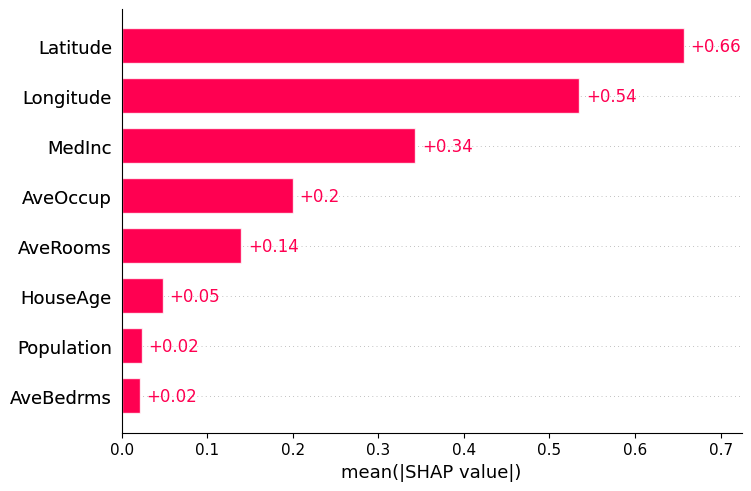

In [32]:
shap.plots.bar(shap_values)

In [33]:
shap_values.abs.mean(axis=0)

.values =
array([0.34329826, 0.04813203, 0.13998409, 0.02158475, 0.02374922,
       0.20024363, 0.65720664, 0.53510218])

.base_values =
np.float64(2.003393038567782)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [34]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.34329825718841844),
 'HouseAge': np.float64(0.04813202554467209),
 'AveRooms': np.float64(0.13998409338520018),
 'AveBedrms': np.float64(0.021584750008826748),
 'Population': np.float64(0.02374922388474761),
 'AveOccup': np.float64(0.20024363486376032),
 'Latitude': np.float64(0.6572066369903058),
 'Longitude': np.float64(0.5351021811533432)}

In [35]:
feature_importances = {feature:shap_val.item() for feature, shap_val in 
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [36]:
feature_importances

{'MedInc': 0.34329825718841844,
 'HouseAge': 0.04813202554467209,
 'AveRooms': 0.13998409338520018,
 'AveBedrms': 0.021584750008826748,
 'Population': 0.02374922388474761,
 'AveOccup': 0.20024363486376032,
 'Latitude': 0.6572066369903058,
 'Longitude': 0.5351021811533432}

In [37]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'Population',
 'AveBedrms']

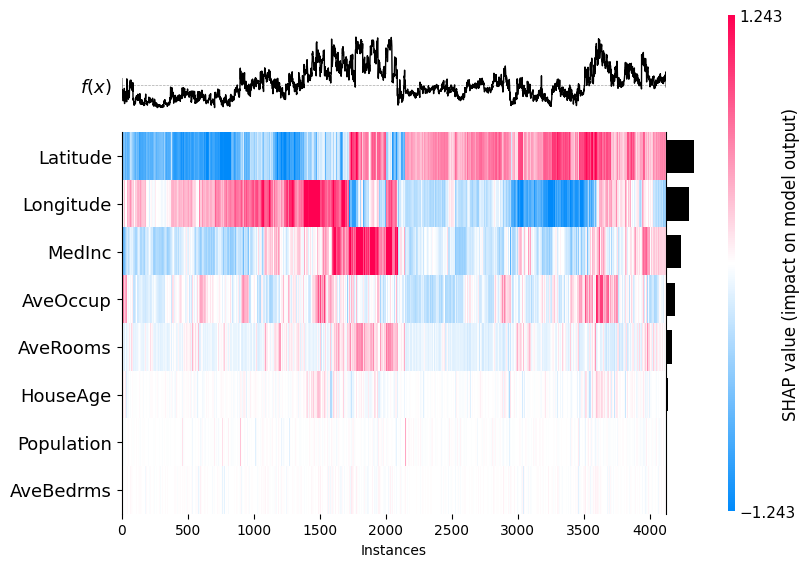

<Axes: xlabel='Instances'>

In [38]:
# heatmap plot

shap.plots.heatmap(shap_values)

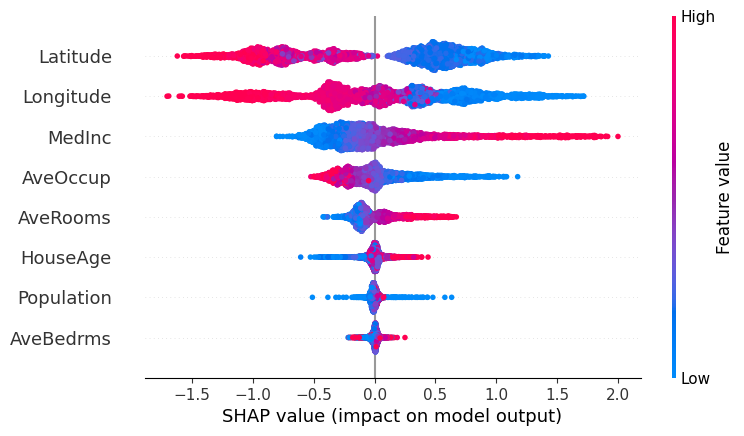

In [39]:
shap.plots.beeswarm(shap_values)

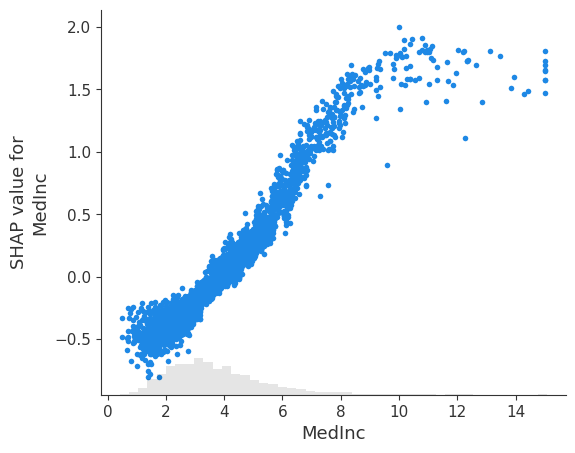

In [40]:
shap.plots.scatter(shap_values[:,"MedInc"])

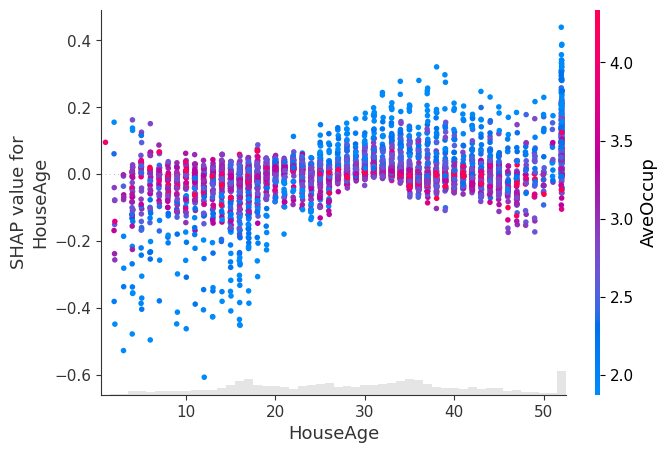

In [41]:
#shap value with interaction
shap.plots.scatter(shap_values[:,"HouseAge"],color = shap_values)

## LOcal PLOTS

In [42]:
test_case = X_test.sample(1)

In [43]:
test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14931,5.6631,4.0,6.131196,1.055908,7985.0,2.976146,32.65,-116.97


In [44]:
explainer_row = explainer(test_case)

In [45]:
explainer_row

.values =
array([[ 0.52422206,  0.00700075,  0.0787173 ,  0.00711906,  0.03150535,
        -0.07182798,  0.87823742, -0.95802513]])

.base_values =
array([2.00339304])

.data =
array([[ 5.66310000e+00,  4.00000000e+00,  6.13119642e+00,
         1.05590757e+00,  7.98500000e+03,  2.97614611e+00,
         3.26500000e+01, -1.16970000e+02]])

In [46]:
explainer_row.shape

(1, 8)

In [47]:
explainer_row[0,:]

.values =
array([ 0.52422206,  0.00700075,  0.0787173 ,  0.00711906,  0.03150535,
       -0.07182798,  0.87823742, -0.95802513])

.base_values =
np.float64(2.0033930385677814)

.data =
array([ 5.66310000e+00,  4.00000000e+00,  6.13119642e+00,  1.05590757e+00,
        7.98500000e+03,  2.97614611e+00,  3.26500000e+01, -1.16970000e+02])

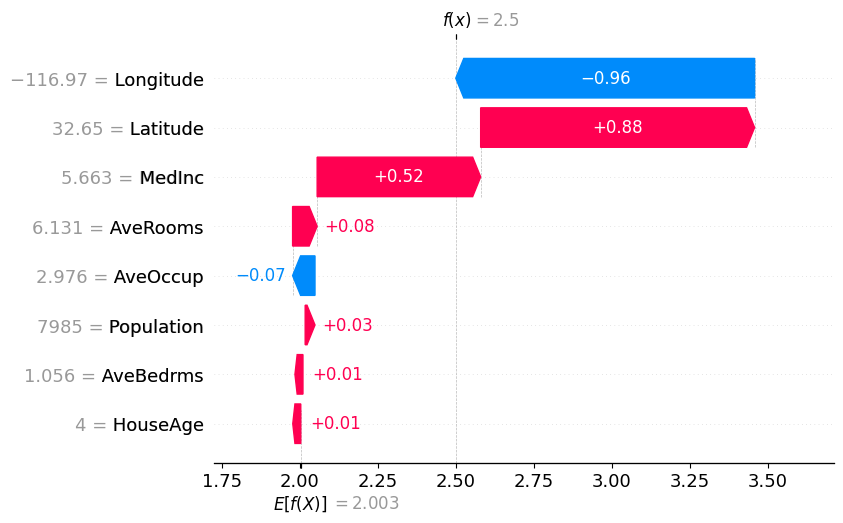

In [48]:
shap.plots.waterfall(explainer_row[0])

In [49]:
shap.plots.initjs()
shap.plots.force(explainer_row[0])

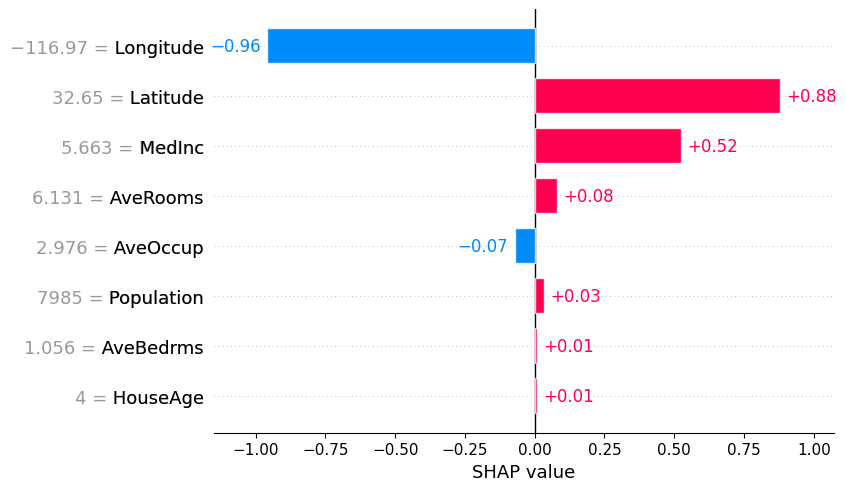

In [50]:
shap.plots.bar(explainer_row[0])

## LIME

In [51]:
test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14931,5.6631,4.0,6.131196,1.055908,7985.0,2.976146,32.65,-116.97


In [ ]:
test_case.values

In [53]:
test_case_lime = test_case.values.flatten()

In [54]:
from lime.lime_tabular import LimeTabularExplainer

In [55]:
X_train.values

array([[   3.2596    ,   33.        ,    5.0176565 , ...,    3.6918138 ,
          32.71      , -117.03      ],
       [   3.8125    ,   49.        ,    4.47354497, ...,    1.73809524,
          33.77      , -118.16      ],
       [   4.1563    ,    4.        ,    5.64583333, ...,    2.72321429,
          34.66      , -120.48      ],
       ...,
       [   2.9344    ,   36.        ,    3.98671727, ...,    3.33206831,
          34.03      , -118.38      ],
       [   5.7192    ,   15.        ,    6.39534884, ...,    3.17889088,
          37.58      , -121.96      ],
       [   2.5755    ,   52.        ,    3.40257649, ...,    2.10869565,
          37.77      , -122.42      ]], shape=(16512, 8))

In [56]:
featute_names = X_train.columns.to_list()

In [57]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [60]:
lime_explainer = LimeTabularExplainer(
    training_data = X_train.values,
    mode = "regression",
    feature_names = feature_names
)

In [62]:
lime_explaination = lime_explainer.explain_instance(
    data_row = test_case_lime,
    predict_fn = xgb_model.predict
)

In [63]:
lime_explaination

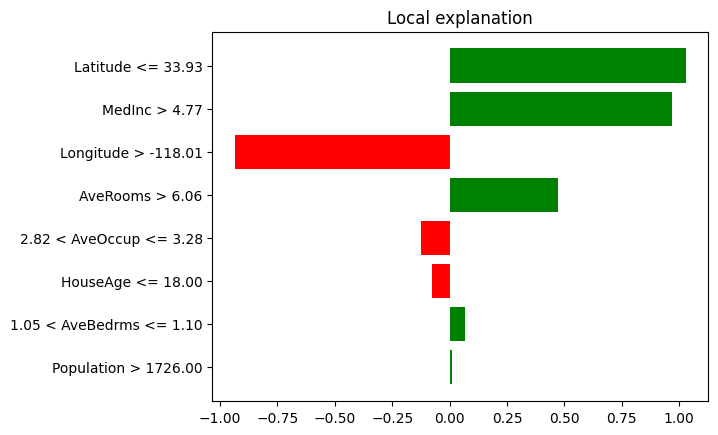

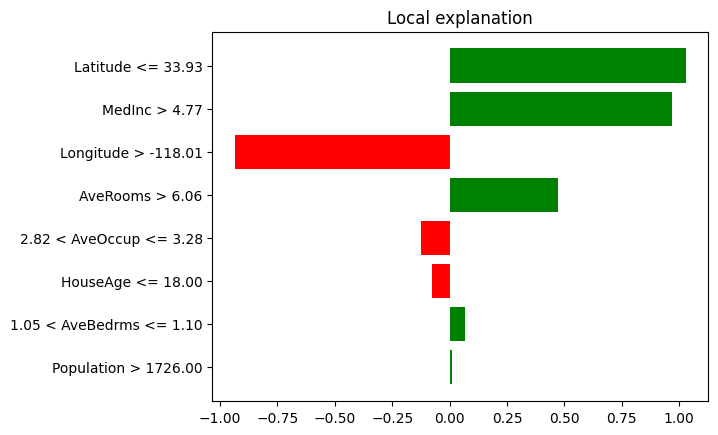

In [64]:
#Lime explaination -->pyplot figure
lime_explaination.as_pyplot_figure()

In [65]:
lime_explaination.as_list()

[('Latitude <= 33.93', 1.0292318339502577),
 ('MedInc > 4.77', 0.9694564984603108),
 ('Longitude > -118.01', -0.9353980700936788),
 ('AveRooms > 6.06', 0.4714350309299376),
 ('2.82 < AveOccup <= 3.28', -0.12582106014414252),
 ('HouseAge <= 18.00', -0.07485326393802497),
 ('1.05 < AveBedrms <= 1.10', 0.06859002309469486),
 ('Population > 1726.00', 0.009857294234092805)]

In [66]:
#Limeexplainations as html
from IPython.core.display import HTML


In [67]:
display(HTML(lime_explaination.as_html()))